<a href="https://colab.research.google.com/github/geo-yrao/ML4ES-tutorials/blob/master/NCICS_ML_lecture_05_MASTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCICS ML Lecture 05: Basic ML workflow with logistic regression and k-nearest neighbors

Welcome to Lecture 5 of the North Carolina Institute for Climate Studies' Machine Learning Course. This session will be our first hands-on lesson in data wrangling and machine learning fundamentals

## Session purpose:

To give you a clear overview of a basic machine learning workflow and to introduce you to one of the two (arguably) most fundamental classification methods: k-nearest neighbors (the other being logistic regression, which we'll cover next time).

## Session contents:

In this session, we will be covering the following topics:
1. Data preprocessing basics;
2. K-nearest neighbors classifiers;
3. Cross-validation;
4. Impact of hyperparameters on model.

## About the data set:

The data set is actually satellite imagery of our home city of Asheville, taken from Landsat 8, an imaging satellite that was launched in 2013.  Check out the following links for more information:

[USGS Landsat Missions: Landsat 8](https://www.usgs.gov/land-resources/nli/landsat/landsat-8?qt-science_support_page_related_con=0#qt-science_support_page_related_con)

[NASA Landsat Science: Landsat 8](https://landsat.gsfc.nasa.gov/landsat-data-continuity-mission/)

# Preprocessing: how to prepare the data

With any machine learning problem, preprocessing the data in order to make it palatable to a machine learning classifier usually takes at least 80% of the investigator's time and effort (at least!).  

In this first section, we will investigate the structure of the files that contain the data we seek to classify.  It is always important to do this first, for any project. Why? It is important because improperly ingested data can result in huge amounts of wasted effort further down the line.

## Mount Google Drive and inspect the data directory

First, let's examine the file that contains our samples in order to understand what its structure is. The directory in which it is stored is located in the NCICS ML training Google Drive folder, so you'll need to connect this Google Colab notebook with Google Drive. Fortunately, that's quite easy to do.

In [ ]:
# First, we need to access the data in Google Cloud. Execute the following code
# and do what the nice computer tells you.
from google.colab import drive

drive.mount("/content/gdrive")

# You ought to see output that looks like the following line. Click on that link.
# # >> Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id...

# Once you've copy/pasted the authorization code that Google generates for you 
# into the text bar, you should see the following lines generated. If you see 
# those, it means that you've successfully connected your Google Colab notebook 
# to your Google Drive!
# # >> Enter your authorization code:
# # >> ··········
# # >> Mounted at /content/gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Define the path and names of our data files.
path_data_dir_bash =\
  "/content/gdrive/My\ Drive/NCICS\ AI\ training/Phase\ 2/Data/Land_cover_Asheville"
path_data_dir =\
  "/content/gdrive/My Drive/NCICS AI training/Phase 2/Data/Land_cover_Asheville/"

# To run a bash command in any notebook cell, simply add an ! before the
# command. For instance, the command to navigate from your current directory
# to a subdirectory named "data" one would execute the following line:
#
# !cd data/
#
# Here, let's see if we can view the directory containing our data.
! ls $path_data_dir_bash

CDL_2017.tif  L8_2017.tif  label_information.txt  NC_L8_GroundTruth.csv


## Ingest the data 

We can see that we have four separate files in the directory. Two of them are actual satellit images! It always helps me to see what I'm classifying, so let's take a look at the images using the [Python Imaging Library (PIL)](https://en.wikipedia.org/wiki/Python_Imaging_Library).

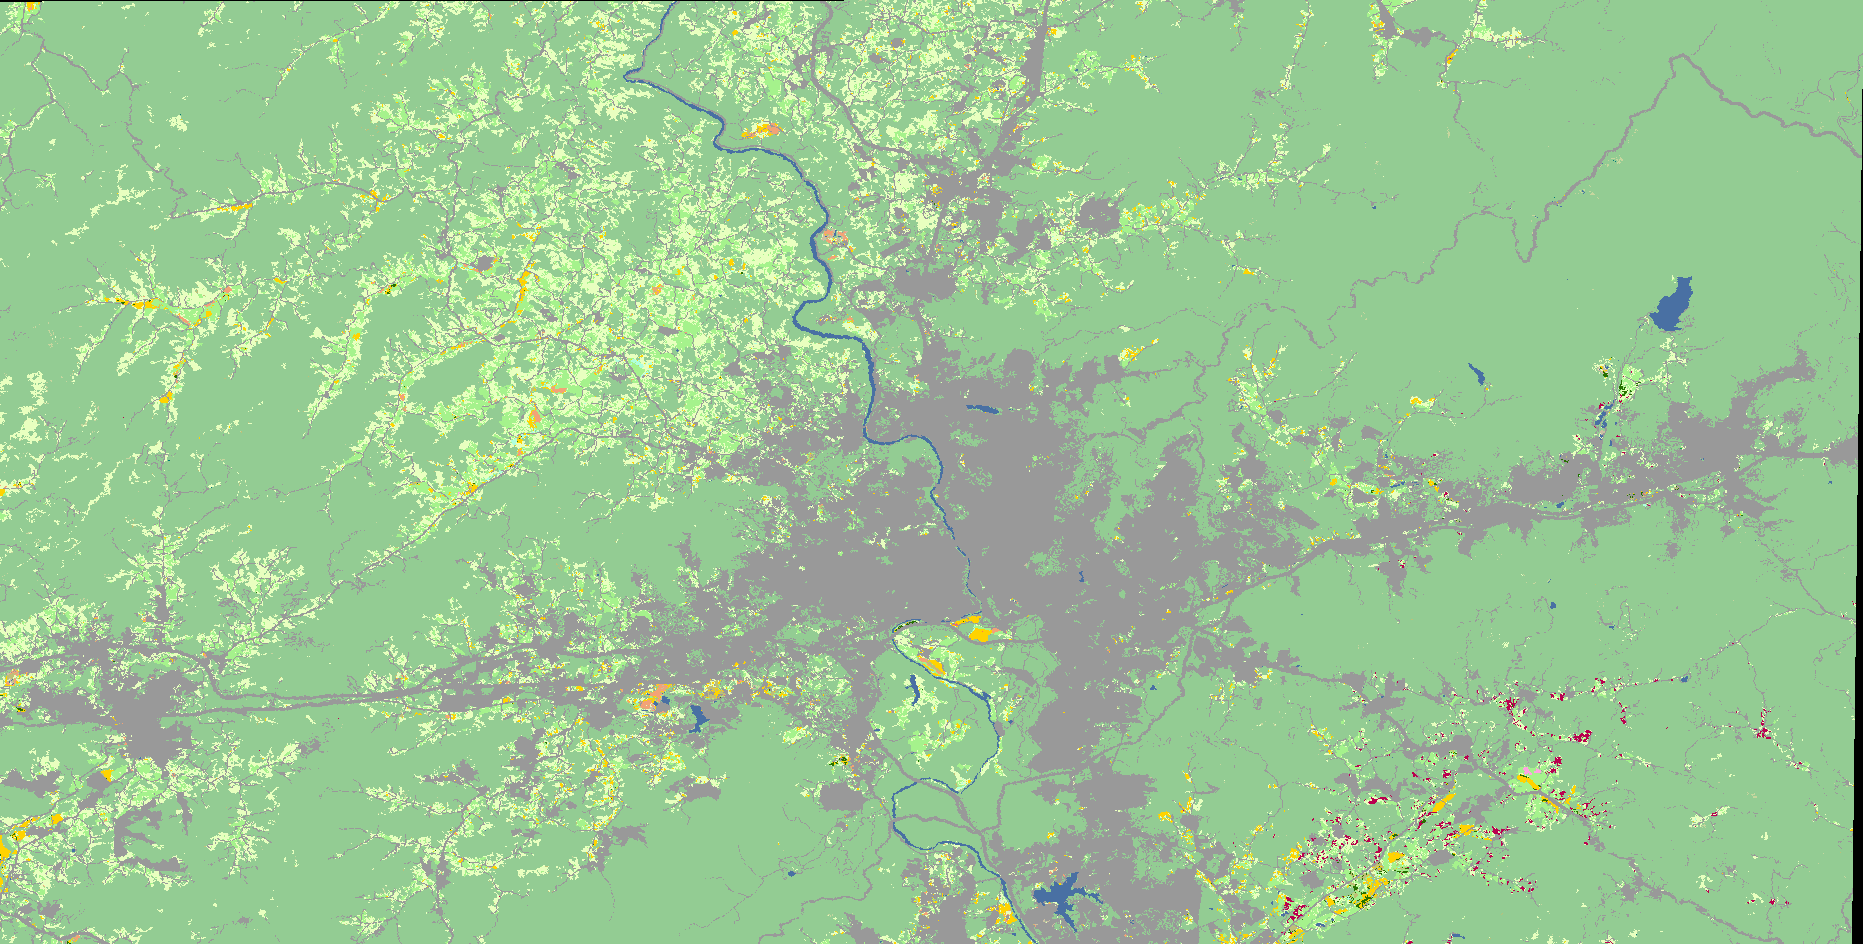

In [ ]:
# Load PIL's Image class.
from PIL import Image

# Import the image.
image = Image.open(path_data_dir+"CDL_2017.tif")

# Display the image.
image

In [ ]:
print("Image size in pixels:", image.size)

Image size in pixels: (1863, 944)


Excellent. Looks like a satellite image! We can see the various types of cover (forest, water, urban/developed, etc.).

In [ ]:
# Above, we can see the data file: NC_L8_GroundTruth.csv. We'll save the name as
# a variable and then inspect its contents.
filename_data = "NC_L8_GroundTruth.csv" 

# Print the first 10 lines of the data file.
! cat $path_data_dir_bash/$filename_data | head

"","Latitude","Longitude","Class","B1","B2","B3","B4","B5","B6"
"1",35.5147693572276,-82.6804514604663,"0",127,150,550,226,3609,1441
"2",35.7539792870272,-82.5204322997573,"0",81,115,426,170,2913,1110
"3",35.7106347084667,-82.3056611655266,"0",156,220,538,477,2492,2077
"4",35.512813962706,-82.4138614941527,"0",245,280,663,507,2732,1531
"5",35.5206355407921,-82.8531809007429,"0",148,181,534,265,3320,1457
"6",35.6190570650421,-82.8078801607458,"0",202,289,651,522,3047,2251
"7",35.5542031467449,-82.5047888787511,"0",208,250,521,408,2905,1738
"8",35.5603952293964,-82.3007725964622,"0",60,91,486,184,3431,1342
"9",35.545729770485,-82.5051147833554,"0",122,155,463,219,3385,1264


It looks like we have a CSV with commas as delimiters (which is nice, since CSV = "Comma Separated Values").  We will now use the popular Python library Pandas to import the file into a pandas.Dataframe object. On the surface, a dataframe is Python's version of an Excel spreadsheet. But because a vast suite of methods lies beneath them, dataframes are quite a powerful tool for exploring data sets.

In [ ]:
# Import Pandas and assign it the shorter alias "pd" to save time and space when calling it in the
# following code cells.
import pandas as pd

I don't remember exactly which keyword arguments to feed the Pandas' method responsible for importing CSV's, so we'll use a handy Python tool for printing a method's documentation.

In [ ]:
# Adding a question mark in front of any variable/method/object while using the
# Python command line or IPython will cause that entity's documentation to be
# printed for the user.
?pd.read_csv

In [ ]:
# Import the data, using the first column as the dataframe's index.
df_data = pd.read_csv(path_data_dir+filename_data, index_col=None)

# Take a look at the first five rows of the dataframe.
df_data.head()

,Unnamed: 0,Latitude,Longitude,Class,B1,B2,B3,B4,B5,B6
0,1,35.514769,-82.680451,0,127,150,550,226,3609,1441
1,2,35.753979,-82.520432,0,81,115,426,170,2913,1110
2,3,35.710635,-82.305661,0,156,220,538,477,2492,2077
3,4,35.512814,-82.413861,0,245,280,663,507,2732,1531
4,5,35.520636,-82.853181,0,148,181,534,265,3320,1457


As some of you may have noticed, this dataframe is 0-indexed, in accordance with Python's standard indexing convention. So, to keep with the Pythonic convention, let's dropt the first column of the dataframe, which was the original row-numbering index, as found in the CSV.

In [ ]:
# Delete the column named "Unnamed: 0", which were the row indices in the CSV.
df_data = df_data.drop(labels=["Unnamed: 0"], axis="columns")

#Let's take a look at some of the basic aspects of this data.
print(df_data.shape)
print(df_data.Class.unique())

(2375, 9)
[0 1 2 3 4]


## View the data and explain the class labels

So, there are 2375 distinct samples and 5 distinct classes, which matches up with what the accompanying text file "label_information.txt" states.  I have copy/pasted the contents of "label_information.txt" below for quick reference.

Class label information:


1.   **Class 0**: forest (includes data from cdl classes: 'forest', 'deciduous forest', 'evergreen forest', 'mixed forest');
2.   **Class 1**: corn (includes data from cdl class 'corn');
3.   **Class 2**: soy (includes data from cdl class 'soybeans');
4.   **Class 3**: developed/urban (includes data from cdl classes 'developed/open space', 'developed/low intensity', 'developed/med intensity', 'developed/high intensity');
5.   **Class 4**: water (includes data from cdl class 'open water').

Now it is time to wrangle the data into a form that can be used by Scikit-learn's machine learning pipeline.

Here, we will use Matplotlib, Python's most popular plotting library, to gain an understanding of the distribution of the classes.  We will use the resulting knowledge to further frame our classification problem.

In [ ]:
# Scikit-learn, one of Python's most popular machine learning libraries, takes
# input data in a standardized format of a numpy array (numpy is Python's most 
# popular numerical processing library) of dimensions "n_samples x n_features". 
# and the class labels as a 1-D numpy array of length "n_samples".  These two
# arrays are frequently referred to in the scikit-learn documentation as "data"
# and "target", respectively; their arrays are commonly names "X" and "y", respectively.
X = df_data.values[:, 3:]  # Data. The six L8 channels in the dataframe.
y = df_data.values[:, 2] # Target. The "class" column in the dataframe.

## Using histograms to understand the distribution of classes

It's important that we develop an understanding of the nature of our training data.  Visualizing the shape of the data we seek to classify is one of the most efficient ways to begin developing this type of understanding.  To visualize, we'll analyze the data using [Numpy](https://numpy.org/), Python's most popular math/numerical analysis library, and then we'll plot the results of the analysis using [Matplotlib](https://matplotlib.org/index.html)'s Pyplot module.  Matplotlib is Python's most popular plotting and visualization library. Pyplot is "a collection of command style functions that make matplotlib work like MATLAB", according to the [Pyplot tutorial](https://matplotlib.org/tutorials/introductory/pyplot.html): it makes plotting in Python quick and easy, as we'll see.


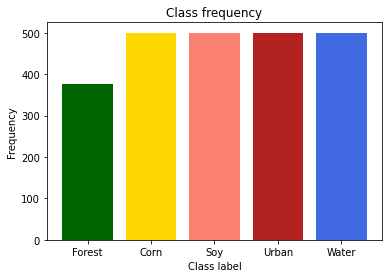

In [ ]:
# Import matplotlib's pyplot module for quick and easy plotting.
import matplotlib.pyplot as plt

# Import numpy, Python's most popular math/numerical analysis library.
import numpy as np

# Get the counts for each of the unique class labels so we can plot their distribution.
unique, counts = np.unique(y, return_counts=True)

# Define a list of the class names to include in the plot.
class_labels_list = ["Forest", "Corn", "Soy", "Urban", "Water"]

# Define a list of attractive colors to use in the notebook's data viz.
class_colors_list = ["darkgreen", "gold", "salmon", "firebrick", "royalblue"]

# Use Matplotlib's Pyplot module to quickly inspect the class distributions.
_ = plt.bar(class_labels_list, counts, color=class_colors_list)

# Use Pyplot to add a title and labels to the x- and y-axises.
plt.title("Class frequency")
plt.xlabel("Class label")
plt.ylabel("Frequency")

# Now that we're done modifying the plot, tell Pyplot to display it.
plt.show()

## Subset to a binary classification problem: forest versus water

It appears that we have a slight class imbalance that disadvantages **Class 0**, which corresponds to "forest".

Reduce this dataset down to a binary classfication problem of distinguishing between areas in the image with that are forested versus areas in the image that are covered with water. This reduction is for simplicity's sake. We will work on classifying all five classes in a subsequent session.



In [ ]:
# Find the array indices for the forest and water samples in the dataset.
indices_samples_forest = np.where(y==0)
indices_samples_water = np.where(y==4)

# # Check that our numpy array indexing yields the correct number of samples/rows.
# print(indices_samples_forest[0].shape)
# print(X[indices_samples_forest].shape)
# print(indices_samples_water[0].shape)
# print(X[indices_samples_water].shape)

# Create a binary data set of the data and the target for corn vs. urban pixels.
X_forest_vs_water = np.concatenate((X[indices_samples_forest], X[indices_samples_water]))
y_forest_vs_water = np.concatenate((y[indices_samples_forest], y[indices_samples_water]))

# Check on the dimensions for sanity.
print(X_forest_vs_water.shape)

(875, 6)


## Examining binary feature space using a scatterplot of the reflectance

Excellent! Now we have a binary dataset.

Before proceeding with training and evaluating our K-nearest neighbor classifier, it is important that we examine our feature set to get a sense of how tractable this machine learning problem may or may not be. And to see if there is any additional preprocessing of the data that we need to do.

Let's first make a scatterplot of Bands 3 and 4 from the data set. Band 2 includes light of the wavelengths 0.45 - 0.51 µm (<a href="https://www.wolframalpha.com/input/?i=0.45+%C2%B5m+color">violet</a>-to-<a href="https://www.wolframalpha.com/input/?i=0.51+%C2%B5m+color">light green</a>). Band 3 includes light of the wavelengths 0.53 - 0.59 µm (<a href="https://www.wolframalpha.com/input/?i=0.53+%C2%B5m+color">green</a>-to-<a href="https://www.wolframalpha.com/input/?i=0.59%C2%B5m+color">orange</a>). Band 4 includes light of the wavelengths 0.64 - 0.67 µm (red-to-deep-red). These bands correspond to green and blue light, respectively. Since we're classifying forest versus water, these ought to be fairly separable features. 

As a side note, <a href="https://www.wolframalpha.com/"> Wolfram Alpha </a> is a quick and easy way to visualize spectra.

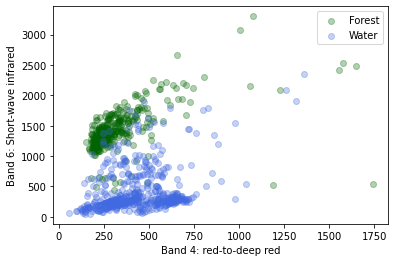

In [ ]:
# Define a Python dictionary object to map the bands' column indices to their
# approximate color spectra names.
band_to_color_map = {
    0: "deep violet-to-violet",
    1: "violet-to-light green",
    2: "green-to-orange",
    3: "red-to-deep red",
    4: "Near-infrared",
    5: "Short-wave infrared",
}
# Define which Landsat-8 bands to include in the scatter plot.
first_band = 3
second_band = 5

# Add some of the plotting aesthetic parameters that you might want to play around with.
alpha = 0.3

# Initialize a new matplotlib figure and its axes object.
fig, ax = plt.subplots()

# Add the forest samples' spectra to the scatter plot.
ax.scatter(
    X_forest_vs_water[:375, first_band],
    X_forest_vs_water[:375, second_band],
    color="darkgreen",
    alpha=alpha,
    label="Forest",
)

# Add the water samples' spectra to the scatter plot.
ax.scatter(
    X_forest_vs_water[375:, first_band],
    X_forest_vs_water[375:, second_band],
    color="royalblue",
    alpha=alpha,
    label="Water",
)

# Add a legend to the plot.
ax.legend()

# Add labels to the x- and y-axes. The code is formatted so the labels will change
# if you modify which bands you're plotting.
ax.set_xlabel(f"Band {first_band+1}: "+band_to_color_map[first_band])
ax.set_ylabel(f"Band {second_band+1}: "+band_to_color_map[second_band])

# Show the plot. Google Colab and Jupyter Lab will do this anyways, but it's 
# good practice. And it avoids printed output from the penultimate line of code.
fig.show()

# Classification: k-nearest neighbors (KNN) with cross-validation (CV) to understand real-world performance.

K-nearest neighbors composes the second half of the ML classifier paradigmatic foundation. **Most machine learning classifiers can, in their most trivial cases, be reduced to either a form of logistic regression or a form of KNN or some combination thereof.**  To learn more about these methods, check out the following links:

[Scikit-Learn's User Guide: Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html)

[Wikipedia: k-nearest neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

[Wikipedia: Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics))


## Methods of data splitting for cross-validation: variants of k-fold splitting and their implications

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


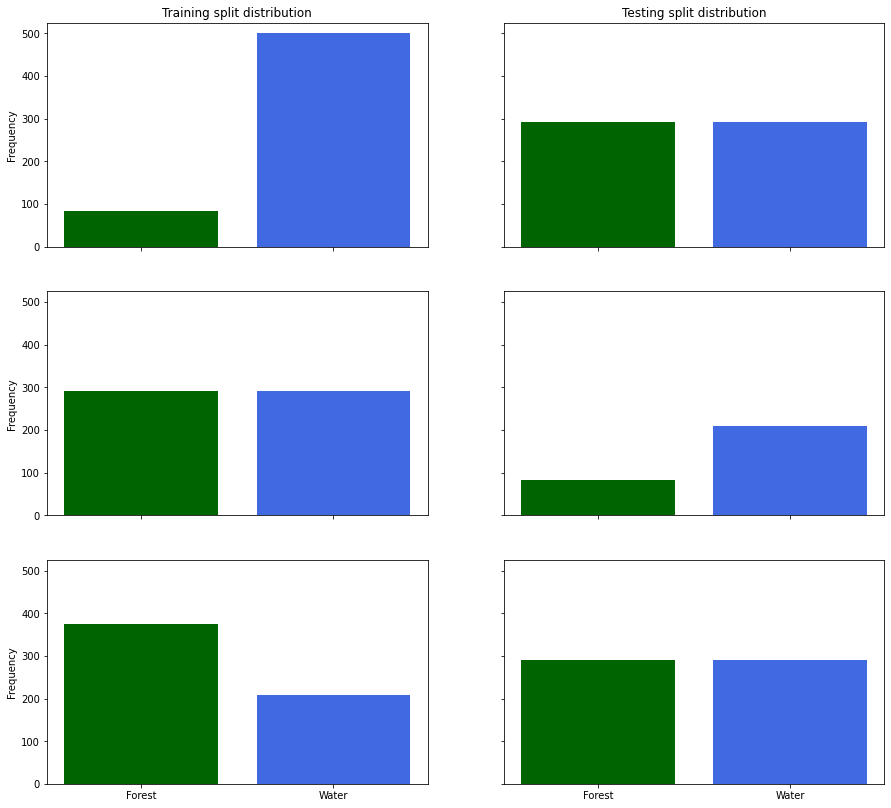

In [ ]:
# Import all of the useful tools we'll need from scikit-learn's modules.
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer

# Initialize a k-fold cross-validation generator to split our data sets for us.
kfold_generator = KFold(n_splits=3, random_state=7)

# Show histograms of class distributions across the splits
labels_list = ["Forest", "Water"]
colors_list = ["darkgreen", "royalblue"]

# Here, instead of using Pyplot's high-level commands, we're going to produce a 
# matplotlib figure with multiple subplots. These subplots are represented by 
# "axes" objects. It's an unfortunate choice of a name, since it makes most of us
# think of the axises of a graph. Here, though, an axes object is a subplot. I'll
# refer to them in the code using "ax". In the case of having multiple subplots, 
# the object stored in "ax" is an array of axes objects: one per subplot.
# Learning Matplotlib can be confusing at first, but it's quite powerful once you
# get the hang of it. 
fig, ax = plt.subplots(3, 2, figsize=(15, 14), sharex=True, sharey=True)

# Iterate through the splits and plot the classes' distributions.
for axes_row_idx, (splits_train, splits_test) in enumerate(kfold_generator.split(X_forest_vs_water)):
    
    # Get this split's training and testing labels.
    y_train = y_forest_vs_water[splits_train]
    y_test = y_forest_vs_water[splits_test]

    # Get the counts for each of the unique class labels so we can plot their distribution.
    _, counts_train = np.unique(y_train, return_counts=True)
    _, counts_test = np.unique(y_test, return_counts=True)

    # Plot the training splits' distributions in the left-hand column and the 
    # testing splits' distributions in the right-hand column. The ";" at the end
    # of the following two lines is to suppress some returned output.
    ax[axes_row_idx][0].bar(labels_list, counts_train, color=colors_list);
    ax[axes_row_idx][1].bar(labels_list, counts_test, color=colors_list);

    # Add a label to the y axis of the left column's subplot.
    ax[axes_row_idx][0].set_ylabel("Frequency")

# Add titles over the left and right columns.
ax[0][0].set_title("Training split distribution")    
ax[0][1].set_title("Testing split distribution")

# Nicely ask the computer to show us the plots.
fig.show()

Notice how imbalanced the classes are in both the training and testing splits. If we were doing many, many more splits, and there weren't a pre-existing class imbalance, then we wouldn't worry as much about this imbalance. But, it has the capacity of interfering with our classifiers' abilities to learn.  

With this problem in mind, let's look at using a stratified k-fold splitting approach. A stratified splitter takes into account the class distributions and accounts for them when randomly shuffling and splitting the samples.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


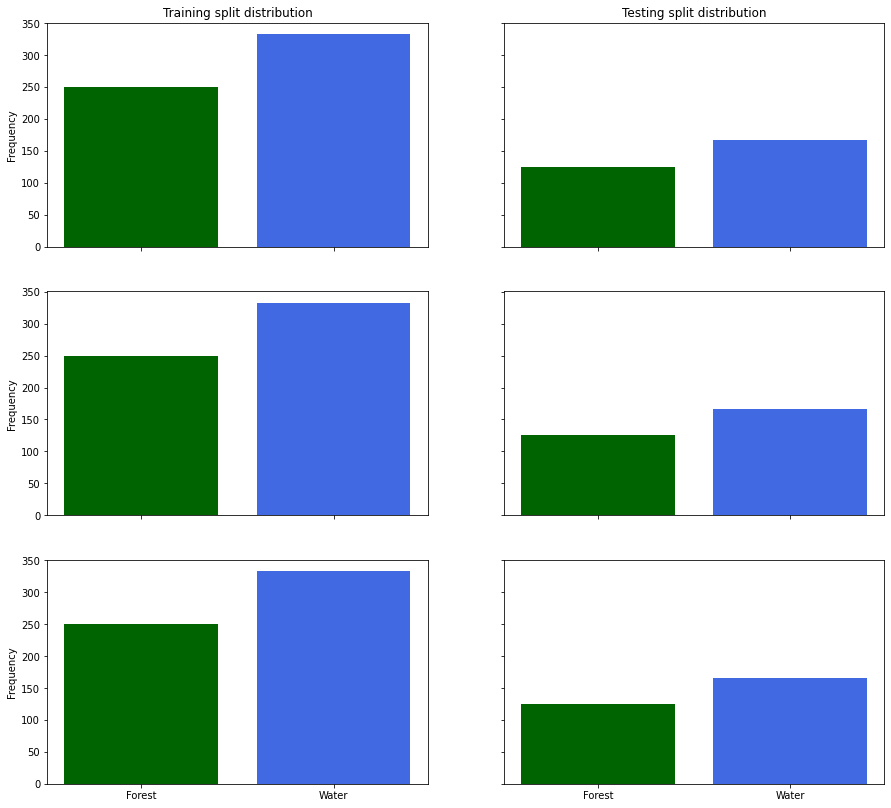

In [ ]:
# Initialize a 3-fold stratified splits generator.
stratified_kfold_generator = StratifiedKFold(n_splits=3, random_state=7)

# Iterate through the splits and plot them.
fig, ax = plt.subplots(3, 2, figsize=(15, 14), sharex=True, sharey=True)
for row_idx, (splits_train, splits_test) in\
    enumerate(stratified_kfold_generator.split(X_forest_vs_water, y_forest_vs_water)):
    
    # Get the training and testing labels.
    y_train = y_forest_vs_water[splits_train]
    y_test = y_forest_vs_water[splits_test]

    # Get the counts for each of the unique class labels so we can plot their distribution.
    _, counts_train = np.unique(y_train, return_counts=True)
    _, counts_test = np.unique(y_test, return_counts=True)

    # Plot this split's class distributions.
    ax[row_idx][0].bar(labels_list, counts_train, color=colors_list);
    ax[row_idx][1].bar(labels_list, counts_test, color=colors_list);

    # Add a label to the shared y-axis.  
    ax[row_idx][0].set_ylabel("Frequency")

# Add separate titles to the two subplots.
ax[0][0].set_title("Training split distribution")    
ax[0][1].set_title("Testing split distribution")

fig.show()

## k-Nearest neighbors classification

Now, it's time to classify. We'll touch up the data just a little bit and then run 10-fold cross-validation on the classifiers to get an idea as to how well this 5-nearest neigbors classifier would work "in the real world" (ie, if it saw brand new data).

In [ ]:
# Binarize the corn and urban sample labels.  We do this step because sklearn's
# classifiers will assume that we're dealing with a multiclass classification
# problem if they see any labels that aren't 0 and 1.
lb = LabelBinarizer()
y_binary = lb.fit_transform(y_forest_vs_water.tolist())

# Initialize a KNN classifier object. Later, we'll train it and then have it predict the
# classes of withheld testing samples.
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Initialize a stratified 10-fold generator for the cross-validation.
stratified_kfold_generator = StratifiedKFold(n_splits=10, random_state=7)

# Iterate through each of the splits and train/test the KNN classifier. We will 
# store the predictions in the following list, "classfication predictions".
classification_predictions = list()
for train, test in stratified_kfold_generator.split(X_forest_vs_water, y_forest_vs_water):

    # Fit the classifier to the training data. This erases the training from any
    # previous iteration of the loop.
    knn_classifier.fit(X_forest_vs_water[train], y_binary[train].ravel())

    # Have the newly trained classifier predict the classes of the withheld testing data.
    y_predicted = knn_classifier.predict(X_forest_vs_water[test])

    # Add the true class labels and the predicted class labels to the storage list.
    classification_predictions.append((y_binary[test].ravel(), y_predicted.ravel()))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


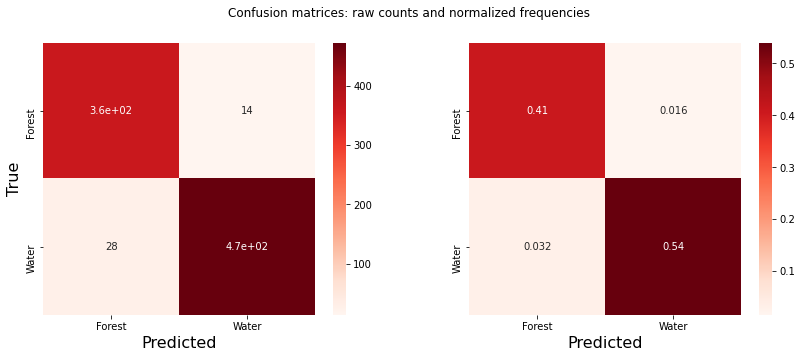

In [ ]:
# Import the plotting library Seaborn (it makes pretty data viz easy) and
# Scikit-Learn's confusion_matrix object so we can plot the confusion matrices.
import seaborn
from sklearn.metrics import confusion_matrix

# Loop through the cached predictions and calculate the aggregate confusion matrix,
# both with the raw counts and another that is normalized by the total number of samples.
cf = np.zeros((2,2))
for y_true, y_pred in classification_predictions:
    cf += confusion_matrix(y_true, y_pred)
cf_normalized = cf/cf.sum()

# Initialize figure, axes for the two confusion matrices.
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot the raw counts' confusion matrix.
seaborn.heatmap(
    cf, cmap="Reds", annot=cf, square=True, cbar=True,
    xticklabels=labels_list, yticklabels=labels_list,
    ax=ax[0]
)

# Add labels to the x-axis and the y-axis.
ax[0].set_xlabel("Predicted", fontsize=16)
ax[0].set_ylabel("True", fontsize=16)

# Plot the percentages' confusion matrix.
seaborn.heatmap(
    cf_normalized, cmap="Reds", annot=True, square=True,
    xticklabels=labels_list, yticklabels=labels_list,
    ax=ax[1]
)

# Add a label to the x-axis.
ax[1].set_xlabel("Predicted", fontsize=16)

# Add a title to the figure.
fig.suptitle("Confusion matrices: raw counts and normalized frequencies")

# Display the figure.
fig.show()

## Evaluation metrics: calculate accuracy and additional evaulation metrics

In [ ]:
# Import the handy classification_report function from sklearn.metrics.
from sklearn.metrics import classification_report

# Load all true labels and all predicted labels into their own arrays.
y_true_concatenated = np.concatenate([y[0] for y in classification_predictions])
y_predicted_concatenated = np.concatenate([y[1] for y in classification_predictions])

# Now print out the classification performance results.
print(
    classification_report(
        y_true_concatenated,
        y_predicted_concatenated,
        target_names=["Forest", "Water"]
    )
)

              precision    recall  f1-score   support

      Forest       0.93      0.96      0.95       375
       Water       0.97      0.94      0.96       500

    accuracy                           0.95       875
   macro avg       0.95      0.95      0.95       875
weighted avg       0.95      0.95      0.95       875



## Hyperparameter optimization: what's the best number of neighbors to consider?

Recall that, although we specified that our classifier use the five nearest neighbors to classify new points, five may not be the optimal number.  Other values of k may, in fact, lead to more accurate classifiers (in the case that we are using accuracy as an evaluation metric).

To find the optimal k, we'll perform a grid search over a range of k's. For each k, we'll run stratified 10-fold cross-validation and average the resultung accuracy from each of the 10 testing splits. 

Whichever value of k has the highest average accuracy will be the value we choose for our final KNN classifier.

This process is, in a nutshell, hyperparameter optimization. It's what most ML practitioners are referring to when they say that they're "training the model".

In [ ]:
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid. In this case, it's just a list of all the
# candidate number of neighbors we'll consider.
n_neighbors_list = [1, 3, 5, 7, 9, 11, 13, 15]
param_grid = {"n_neighbors" : n_neighbors_list}

# Initialize a KNN classifier object. 
knn_classifier = KNeighborsClassifier()

# Initialize a stratified 10-fold generator for the cross-validation.
stratified_kfold_generator = StratifiedKFold(n_splits=10, random_state=7)

# Create the grid search object. This object will take the KNN classifier
# and run stratified 10-fold cross-validation for each of the potential
# candidates for k. It will record the averaged accuracy for each k so
# that afterwards we can view how the classifier's accuracy improves or
# worsens with respect to k.
gridsearch_cv_obj = GridSearchCV(
    knn_classifier, 
    param_grid, 
    scoring=make_scorer(accuracy_score), 
    cv=stratified_kfold_generator,
    n_jobs=-1,
  )

# Run the grid search for the optimal number of neighbors, k.
gridsearch_cv_obj.fit(X_forest_vs_water, y_binary);

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=False),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(accuracy_score), verbose=0)

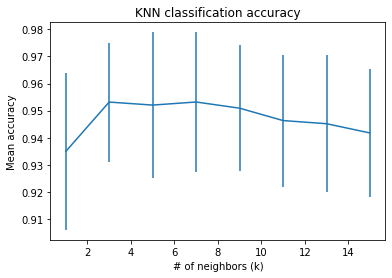

In [ ]:
mean_test_accuracy = gridsearch_cv_obj.cv_results_["mean_test_score"]
std_test_accuracy = gridsearch_cv_obj.cv_results_["std_test_score"]

fig, ax = plt.subplots()

ax.errorbar(
    x=n_neighbors_list,
    y=mean_test_accuracy,
    yerr=std_test_accuracy,
    solid_capstyle="round"
)
ax.set(
    xlabel="# of neighbors (k)", 
    ylabel="Mean accuracy", 
    title="KNN classification accuracy"
);

In [ ]:
# Print the optimal number of neighbors, k.
print("Optimal number of neighbors:", gridsearch_cv_obj.best_params_)
print("Best accuracy:", gridsearch_cv_obj.best_score_)

{'n_neighbors': 7}
0.9531739811912227


# Evaluate the optimized model

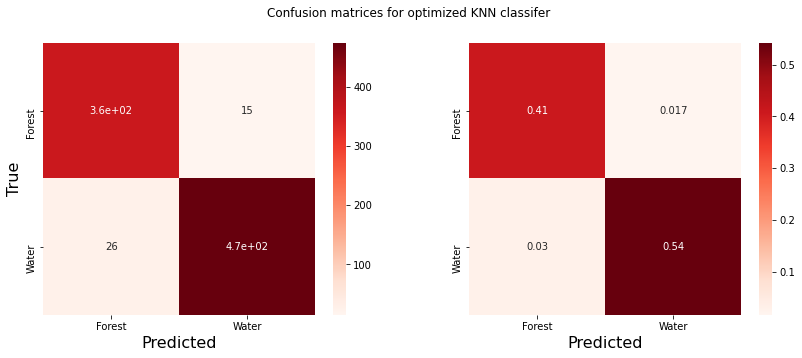

In [ ]:
# Initialize a KNN classifier object. 
knn_classifier = KNeighborsClassifier(n_neighbors=7)

# For those of you interested in a slightly faster and more Pythonic way of 
# coding this, you can use the following list comprehension to achieve the same
# goal. I personally prefer running the latter method, although the former
# method is much clearer for someone who isn't use to Python's list comprehensions.
# This list comprehension isn't faster in any meaningful way in this case, but
# it's a good tool to know about for speeding up loops that are taking a long time.
classification_predictions = [
    (
        y_binary[test].ravel(),     # Store the true labels for the test data.
        knn_classifier.fit(         # Fit the KNN classifier to the training data.
            X_forest_vs_water[train], y_binary[train].ravel()
        ).predict(                  # Feed the testing data to the trained classifier
            X_forest_vs_water[test]
        )
    )
    for train, test in stratified_kfold_generator.split(X_forest_vs_water, y_forest_vs_water)
]

# Loop through the cached predictions and calculate the aggregate confusion matrix,
# both with the raw counts and another that is normalized by the total number of samples.
cf = np.zeros((2,2))
for y_true, y_pred in classification_predictions:
    cf += confusion_matrix(y_true, y_pred)
cf_normalized = cf/cf.sum()

# Initialize figure, axes for the two confusion matrices.
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot the raw counts' confusion matrix.
seaborn.heatmap(
    cf, cmap="Reds", annot=cf, square=True, cbar=True,
    xticklabels=labels_list, yticklabels=labels_list,
    ax=ax[0]
)

# Add labels to the x-axis and the y-axis.
ax[0].set_xlabel("Predicted", fontsize=16)
ax[0].set_ylabel("True", fontsize=16)

# Plot the percentages' confusion matrix.
seaborn.heatmap(
    cf_normalized, cmap="Reds", annot=True, square=True,
    xticklabels=labels_list, yticklabels=labels_list,
    ax=ax[1]
)

# Add a label to the x-axis.
ax[1].set_xlabel("Predicted", fontsize=16)

# Add a title to the figure.
fig.suptitle("Confusion matrices for optimized KNN classifer")

# Display the figure.
fig.show()